<a href="https://colab.research.google.com/github/Az140304/MachineLearning/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Environment

## Install libraries

In [1]:
%pip install tensorflow pandas matplotlib seaborn numpy scipy kaggle

Note: you may need to restart the kernel to use updated packages.


## Import libraries

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data preparation

## Data exploration

In [3]:
data_dir = 'data/trash_dataset'
os.listdir(data_dir)

['bottlecap',
 'cans',
 'cardboard',
 'ceramicsbowl',
 'disc',
 'galvanizedsteel',
 'glassbottle',
 'newspaper',
 'paper',
 'pen',
 'plasticbag',
 'plasticbottle',
 'rag',
 'spoonfork',
 'tire',
 'watergallon']

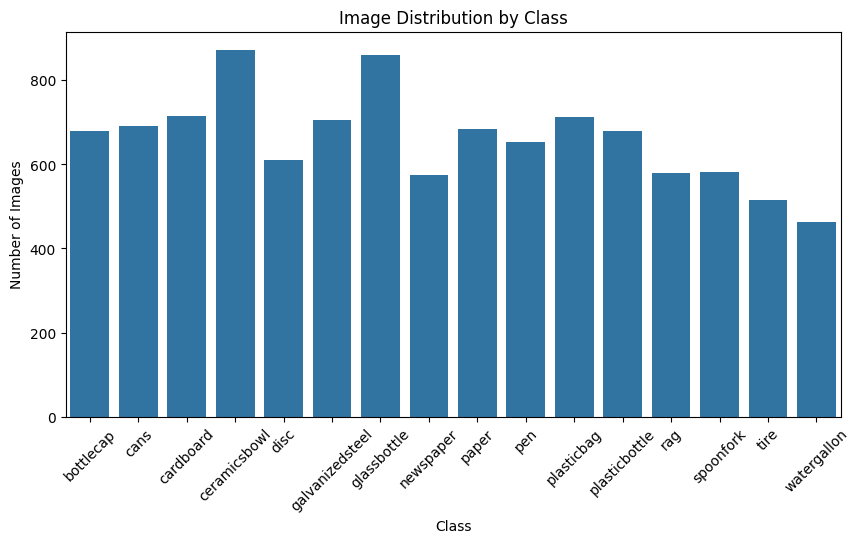

In [4]:
from collections import Counter

class_counts = Counter()
for class_name in os.listdir(data_dir):
    class_counts[class_name] = len(os.listdir(os.path.join(data_dir, class_name)))

plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Image Distribution by Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

## Data cleaning

In [5]:
def verify_image(filepath):
    try:
        with Image.open(filepath) as img:
            img.verify()
        return True
    except (IOError, SyntaxError):
        print(f"Corrupted or unsupported file: {filepath}")
        return False

def clean_directory(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(root, file)
            if not verify_image(filepath):
                os.remove(filepath)

clean_directory(data_dir)

## Split dataset

In [12]:
output_dir = "data/split_data"

# Membuat folder output
os.makedirs(f"{output_dir}/train", exist_ok=True)
os.makedirs(f"{output_dir}/val", exist_ok=True)
os.makedirs(f"{output_dir}/test", exist_ok=True)

# Iterasi tiap kelas
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        # Membuat folder kelas di train/val/test
        os.makedirs(f"{output_dir}/train/{class_name}", exist_ok=True)
        os.makedirs(f"{output_dir}/val/{class_name}", exist_ok=True)
        os.makedirs(f"{output_dir}/test/{class_name}", exist_ok=True)
        
        # Dapatkan semua file gambar di kelas tersebut
        files = os.listdir(class_path)
        files = [os.path.join(class_path, f) for f in files]
        
        # Split menjadi train dan temp (80-20)
        train_files, temp_files = train_test_split(files, test_size=0.2, random_state=42)
        
        # Split temp menjadi val dan test (50-50 dari 20%)
        val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)
        
        # Pindahkan file ke folder masing-masing
        for file in train_files:
            shutil.copy(file, f"{output_dir}/train/{class_name}")
        for file in val_files:
            shutil.copy(file, f"{output_dir}/val/{class_name}")
        for file in test_files:
            shutil.copy(file, f"{output_dir}/test/{class_name}")

# Preprocessing Data

In [6]:
target_size = (128, 128)
batch_size = 32

## Augmentasi data

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

## Load Dataset

In [8]:
# Training data
train_flow = train_datagen.flow_from_directory(
    'data/split_data/train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Validation data
val_flow = test_val_datagen.flow_from_directory(
    'data/split_data/val',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Testing data
test_flow = test_val_datagen.flow_from_directory(
    'data/split_data/test',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 8457 images belonging to 16 classes.
Found 1056 images belonging to 16 classes.
Found 1066 images belonging to 16 classes.


# Build and train model

## Build model

In [9]:
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(train_flow.num_classes, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,620,880 (10.00 MB)

 Trainable params: 362,896 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Compile model

In [10]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Train model

In [11]:
history = model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=20
)

d:\Project Code\Coding\Python\Capstone Project\MachineLearning\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 182s 670ms/step - accuracy: 0.3716 - loss: 2.0290 - val_accuracy: 0.7680 - val_loss: 0.6634
Epoch 2/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 97s 365ms/step - accuracy: 0.6764 - loss: 1.0152 - val_accuracy: 0.8248 - val_loss: 0.5525
Epoch 3/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 94s 356ms/step - accuracy: 0.7033 - loss: 0.9114 - val_accuracy: 0.8125 - val_loss: 0.5333
Epoch 4/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 95s 359ms/step - accuracy: 0.7434 - loss: 0.8012 - val_accuracy: 0.8248 - val_loss: 0.5302
Epoch 5/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 99s 374ms/step - accuracy: 0.7668 - loss: 0.7494 - val_accuracy: 0.8475 - val_loss: 0.4832
Epoch 6/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 98s 368ms/step - accuracy: 0.7805 - loss: 0.6892 - val_accuracy: 0.8655 - val_loss: 0.4682
Epoch 7/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 85s 320ms/step - accuracy: 0.7813 - loss: 0.6819 - val_accuracy: 0.8608 - val_loss: 0.4615
Epoch 8/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 82s 311ms/step - accuracy: 0.7954 - loss: 

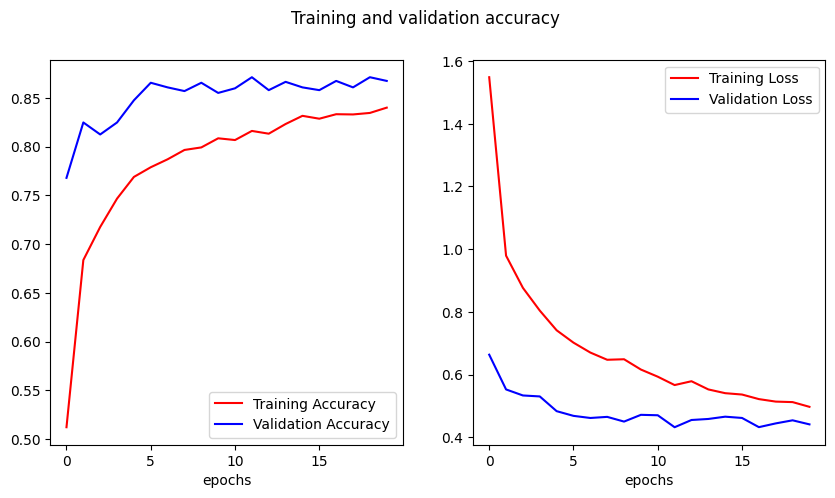

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

# Model evaluation

Test preparation

In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_flow = test_datagen.flow_from_directory(
    'data/trash_dataset',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 10579 images belonging to 16 classes.


## Evaluate model

In [14]:
test_loss, test_accuracy = model.evaluate(test_flow, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

331/331 ━━━━━━━━━━━━━━━━━━━━ 57s 171ms/step - accuracy: 0.9338 - loss: 0.2208
Test Loss: 0.2656
Test Accuracy: 0.9162


Generate predictions

In [15]:
predictions = model.predict(test_flow)
y_pred = np.argmax(predictions, axis=1)
y_true = test_flow.classes

331/331 ━━━━━━━━━━━━━━━━━━━━ 58s 172ms/step


Classification report

In [16]:
class_labels = list(test_flow.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:
                 precision    recall  f1-score   support

      bottlecap       0.98      0.93      0.95       680
           cans       0.81      0.95      0.87       692
      cardboard       0.87      0.97      0.92       716
   ceramicsbowl       0.94      0.98      0.96       872
           disc       0.96      0.97      0.97       611
galvanizedsteel       0.96      0.96      0.96       706
    glassbottle       0.89      0.83      0.86       859
      newspaper       0.94      0.96      0.95       575
          paper       0.86      0.82      0.84       683
            pen       0.98      0.94      0.96       653
     plasticbag       0.91      0.85      0.87       712
  plasticbottle       0.90      0.70      0.79       679
            rag       0.91      0.92      0.92       579
      spoonfork       0.98      0.98      0.98       583
           tire       0.95      0.99      0.97       515
    watergallon       0.86      0.98      0.92       464

     

## Confusion matrix

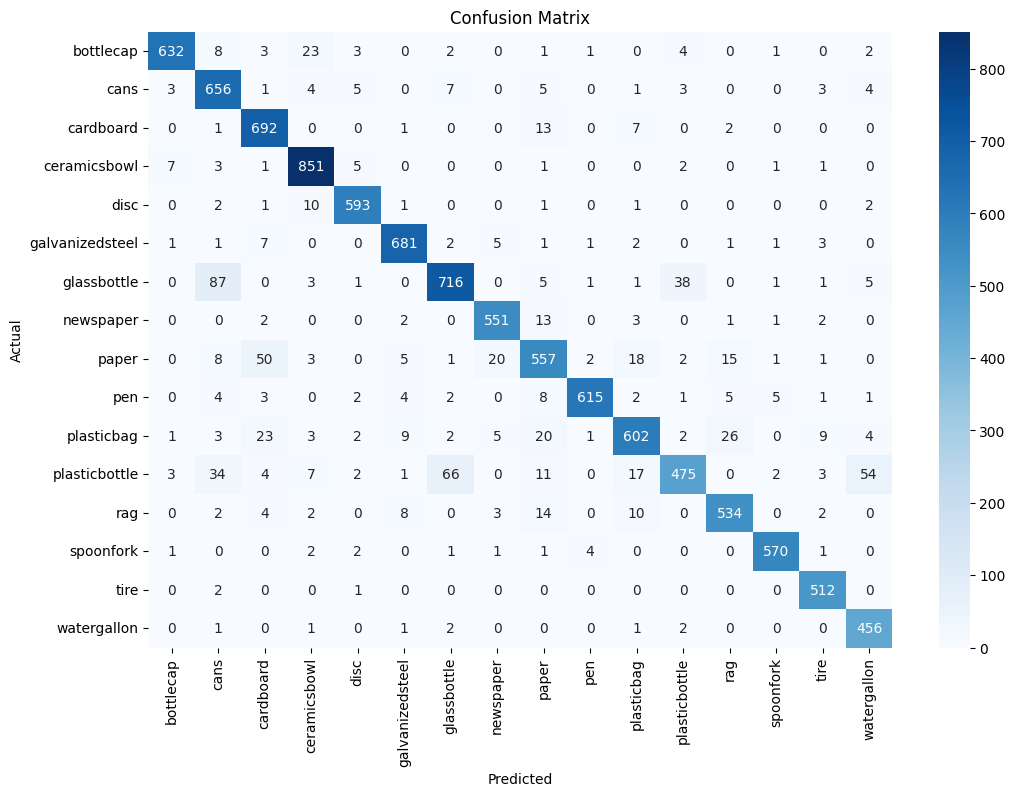

In [17]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Save model

In [18]:
model_dir = "model_result/"

model.save(f"{model_dir}tl_trash_model.h5")